# HAVEN Analysis

Detailed timeline of Person Tracking, Actions, and Safety Events.

Saved: D:\HAVEN\backend\outputs\log.png


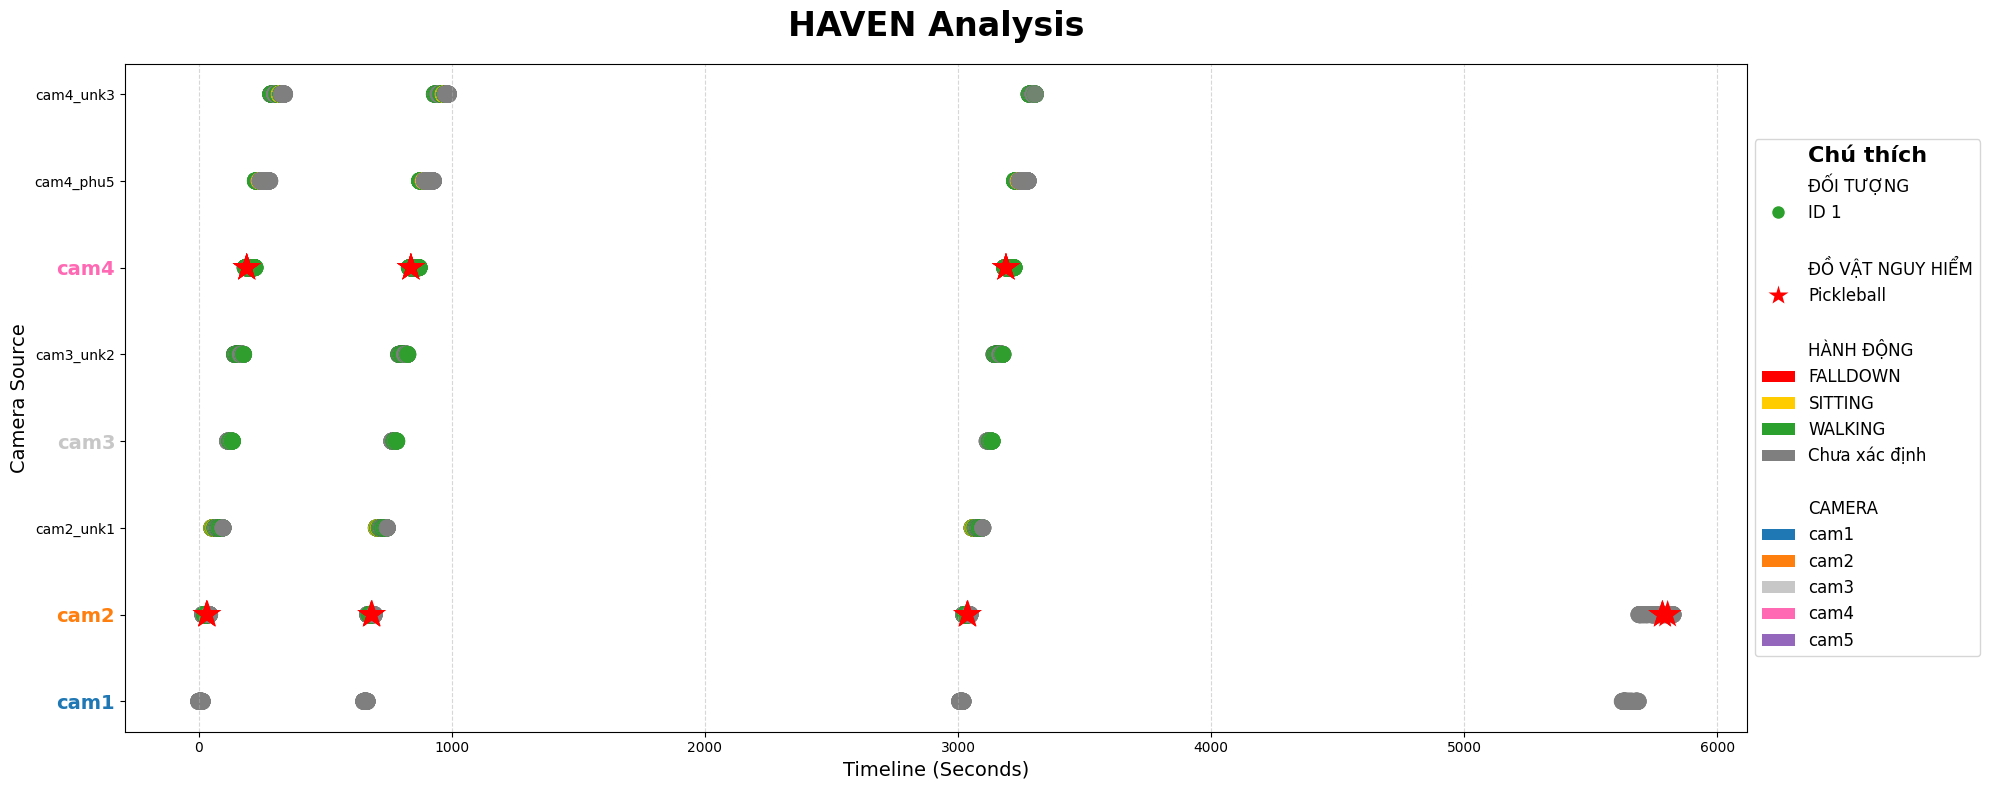

In [3]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
import matplotlib.patches as mpatches
import matplotlib.lines as mlines

# --- CONFIGURATION ---
CSV_PATH = Path(r"D:/HAVEN/backend/outputs/log.csv")
plt.style.use('default')

# --- CUSTOM COLORS ---
ACTION_COLORS = {
    'FALLDOWN': 'red',      # Red
    'SITTING': '#ffcc00',   # Yellow
    'WALKING': '#2ca02c',   # Green
    'STANDING': '#2ca02c',  # Green
    'Unknown': '#7f7f7f'    # Grey
}

CAM_COLORS = {
    'cam1': '#1f77b4',      # Blue
    'cam2': '#ff7f0e',      # Orange
    'cam3': '#c7c7c7',      # Light Gray
    'cam4': '#ff69b4',      # Pink
    'cam5': '#9467bd',      # Purple
}

# --- DATA PROCESSING ---
if CSV_PATH.exists():
    df = pd.read_csv(CSV_PATH)
    
    # Preprocess
    df['posture'] = df['posture'].fillna('Unknown')
    df['objects'] = df['objects'].fillna('')
    
    # Parse Time
    filename = CSV_PATH.stem
    try:
        date_part = filename.split('_')[1]
        date_formatted = f"{date_part[:4]}-{date_part[4:6]}-{date_part[6:]}"
        df['timestamp_dt'] = pd.to_datetime(f"{date_formatted} " + df['timestamp'], errors='coerce')
    except:
        df['timestamp_dt'] = pd.to_datetime(df['timestamp'], format="%H:%M:%S.%f", errors='coerce')
        
    df_clean = df.dropna(subset=['timestamp_dt'])
    start_time = df_clean['timestamp_dt'].min()
    df_clean['seconds'] = (df_clean['timestamp_dt'] - start_time).dt.total_seconds()
    
    # --- EXTRACT CAMERA FOLDER NAME ---
    def extract_cam(cam_str):
        """Extract camera folder name like 'cam1' from possibly nested path"""
        if '/' in cam_str or '\\' in cam_str:
            # e.g. "cam1/video.mp4" -> "cam1"
            return cam_str.split('/')[0].split('\\')[0]
        else:
            # already "cam1"
            return cam_str
    
    df_clean['camera_folder'] = df_clean['camera'].apply(extract_cam)
    
    # --- VISUALIZATION ---
    fig, ax = plt.subplots(figsize=(20, 8))
    
    # 1. Main Scatter (Actions) - USE camera_folder for y-axis
    df_clean['color'] = df_clean['posture'].map(ACTION_COLORS).fillna('#7f7f7f')
    
    ax.scatter(df_clean['seconds'], df_clean['camera_folder'], 
               c=df_clean['color'], s=150, alpha=0.8, edgecolors='none', label='_nolegend_')
    
    # 2. Objects (Pickleball/Danger) - Solid Red Star
    obj_df = df_clean[df_clean['objects'] != ""]
    if not obj_df.empty:
        ax.scatter(obj_df['seconds'], obj_df['camera_folder'], 
                   marker='*', s=450, color='red', edgecolors='none',
                   label='Object', zorder=10)

    # 3. Y-Axis Camera Colors
    cameras = sorted(df_clean['camera_folder'].unique())
    
    # Customize Axis Labels color
    yticklabels = ax.get_yticklabels()
    for label in yticklabels:
        txt = label.get_text()
        if txt in CAM_COLORS:
            label.set_color(CAM_COLORS[txt])
            label.set_fontweight('bold')
            label.set_fontsize(14)

    # 4. Custom Legend (Right Side - "Chú thích")
    legend_elements = []
    
    # ID Section
    legend_elements.append(mpatches.Patch(color='none', label='ĐỐI TƯỢNG'))
    legend_elements.append(mlines.Line2D([], [], color='white', marker='o', markerfacecolor='#2ca02c', markersize=10, label='ID 1'))
    
    # Object Section
    legend_elements.append(mpatches.Patch(color='none', label=''))
    legend_elements.append(mpatches.Patch(color='none', label='ĐỒ VẬT NGUY HIỂM'))
    legend_elements.append(mlines.Line2D([], [], color='white', marker='*', markerfacecolor='red', markeredgecolor='none', markersize=15, label='Pickleball'))
    
    # Action Colors Section
    legend_elements.append(mpatches.Patch(color='none', label=''))
    legend_elements.append(mpatches.Patch(color='none', label='HÀNH ĐỘNG'))
    # Explicitly list order
    for action in ['FALLDOWN', 'SITTING', 'WALKING', 'Unknown']:
        color = ACTION_COLORS.get(action, '#7f7f7f')
        label_text = action if action != 'Unknown' else 'Chưa xác định'
        legend_elements.append(mpatches.Patch(facecolor=color, label=label_text, edgecolor='none'))

    # Camera Colors Section
    legend_elements.append(mpatches.Patch(color='none', label=''))
    legend_elements.append(mpatches.Patch(color='none', label='CAMERA'))
    for cam in ['cam1', 'cam2', 'cam3', 'cam4', 'cam5']:
        if cam in CAM_COLORS:
             legend_elements.append(mpatches.Patch(facecolor=CAM_COLORS[cam], label=cam, edgecolor='none'))

    # Place Legend
    leg = ax.legend(handles=legend_elements, title="Chú thích", 
                    loc='center left', bbox_to_anchor=(1, 0.5), 
                    fontsize=12, title_fontsize=16, frameon=True)
    leg.get_title().set_fontweight('bold')

    # Grid & Titles
    ax.set_title("HAVEN Analysis", fontsize=24, fontweight='bold', pad=20)
    ax.set_xlabel("Timeline (Seconds)", fontsize=14)
    ax.set_ylabel("Camera Source", fontsize=14)
    ax.grid(True, axis='x', linestyle='--', alpha=0.5)
    
    plt.tight_layout()
    
    # Save
    output_dir = Path(r"D:/HAVEN/backend/outputs")
    output_img = output_dir / f"{filename}.png"
    plt.savefig(output_img, dpi=100, bbox_inches='tight')
    print(f"Saved: {output_img}")
    plt.show()